### Libraries and Warning Suppression

In [1]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score, confusion_matrix
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Warning Suppression
import warnings
warnings.filterwarnings('ignore')

### Helper Function

In [3]:
# Helper function for score aggregation
def aggregate_classes(score):
    if score < 55:
        return "Below 55"
    elif score <= 60:
        return "55-60"
    elif score <= 65:
        return "61-65"
    elif score <= 70:
        return "66-70"
    elif score <= 75:
        return "71-75"
    elif score <= 80:
        return "76-80"
    else:
        return "81+"

### Load Dataset and Preprocess data

In [4]:
# Load and preprocess data
df = pd.read_csv("student_performance/StudentPerformanceFactorsAdjusted.csv")

# Encode categorical variables
label_encoders = {}
categorical_columns = df.select_dtypes(include='object').columns

for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Prepare features and target
X = df.drop('Exam_Score', axis=1)
y = df['Exam_Score'].map(aggregate_classes)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

### Untuned without SMOTE

In [5]:
# Define scorers
scorers = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score, average='weighted', zero_division=0),
    'recall': make_scorer(recall_score, average='weighted', zero_division=0),
    'f1': make_scorer(f1_score, average='weighted', zero_division=0),
    'roc_auc': make_scorer(roc_auc_score, average='macro', multi_class='ovr')
}

In [6]:
# Initial model evaluation (before tuning, before SMOTE)
print("\nEvaluating initial model (before tuning, before SMOTE)...")
initial_svm = SVC(random_state=42)


Evaluating initial model (before tuning, before SMOTE)...


In [7]:
# Tuning
cv_results = cross_validate(initial_svm, X_scaled, y, cv=5, scoring=scorers)

metrics_before_tuning = {
    "Accuracy": (cv_results['test_accuracy'].mean(), cv_results['test_accuracy'].std()),
    "Precision": (cv_results['test_precision'].mean(), cv_results['test_precision'].std()),
    "Recall": (cv_results['test_recall'].mean(), cv_results['test_recall'].std()),
    "F1": (cv_results['test_f1'].mean(), cv_results['test_f1'].std()),
    "AUC": (cv_results['test_roc_auc'].mean(), cv_results['test_roc_auc'].std())
}

print("\nMetrics before tuning (original data):")
for metric, (mean, std) in metrics_before_tuning.items():
    print(f"{metric}: Mean = {mean:.4f}, Std = {std:.4f}")


Metrics before tuning (original data):
Accuracy: Mean = 0.8506, Std = 0.0072
Precision: Mean = 0.8440, Std = 0.0072
Recall: Mean = 0.8506, Std = 0.0072
F1: Mean = 0.8385, Std = 0.0058
AUC: Mean = nan, Std = nan


### Tuned without SMOTE

In [8]:
# Define scorers
scorers = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score, average='weighted', zero_division=0),
    'recall': make_scorer(recall_score, average='weighted', zero_division=0),
    'f1': make_scorer(f1_score, average='weighted', zero_division=0),
    'roc_auc': make_scorer(roc_auc_score, average='macro', multi_class='ovr')
}

In [9]:
# Hyperparameter tuning on original data
print("\nPerforming hyperparameter tuning on original data...")
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['rbf', 'linear'],
    'gamma': ['scale', 'auto', 0.1]
}


Performing hyperparameter tuning on original data...


In [10]:
grid_search = GridSearchCV(SVC(random_state=42), param_grid, cv=5, scoring='f1_weighted', n_jobs=-1)
grid_search.fit(X_scaled, y)
best_svm = grid_search.best_estimator_

In [12]:
# Evaluate tuned model on original data
cv_results_tuned = cross_validate(best_svm, X_scaled, y, cv=5, scoring=scorers)

metrics_after_tuning = {
    "Accuracy": (cv_results_tuned['test_accuracy'].mean(), cv_results_tuned['test_accuracy'].std()),
    "Precision": (cv_results_tuned['test_precision'].mean(), cv_results_tuned['test_precision'].std()),
    "Recall": (cv_results_tuned['test_recall'].mean(), cv_results_tuned['test_recall'].std()),
    "F1": (cv_results_tuned['test_f1'].mean(), cv_results_tuned['test_f1'].std()),
    "AUC": (cv_results_tuned['test_roc_auc'].mean(), cv_results_tuned['test_roc_auc'].std())
}

print("\nMetrics after tuning (original data):")
for metric, (mean, std) in metrics_after_tuning.items():
    print(f"{metric}: Mean = {mean:.4f}, Std = {std:.4f}")


Metrics after tuning (original data):
Accuracy: Mean = 0.8710, Std = 0.0066
Precision: Mean = 0.8644, Std = 0.0068
Recall: Mean = 0.8710, Std = 0.0066
F1: Mean = 0.8664, Std = 0.0067
AUC: Mean = nan, Std = nan


### Untuned with SMOTE

In [13]:
# Apply SMOTE
print("\nApplying SMOTE...")
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X_scaled, y)


Applying SMOTE...


In [14]:
# Evaluate initial model on SMOTE data
print("\nEvaluating initial model on SMOTE data...")
cv_results_smote = cross_validate(initial_svm, X_balanced, y_balanced, cv=5, scoring=scorers)

metrics_before_smote = {
    "Accuracy": (cv_results_smote['test_accuracy'].mean(), cv_results_smote['test_accuracy'].std()),
    "Precision": (cv_results_smote['test_precision'].mean(), cv_results_smote['test_precision'].std()),
    "Recall": (cv_results_smote['test_recall'].mean(), cv_results_smote['test_recall'].std()),
    "F1": (cv_results_smote['test_f1'].mean(), cv_results_smote['test_f1'].std()),
    "AUC": (cv_results_smote['test_roc_auc'].mean(), cv_results_smote['test_roc_auc'].std())
}

print("\nMetrics before tuning (SMOTE data):")
for metric, (mean, std) in metrics_before_smote.items():
    print(f"{metric}: Mean = {mean:.4f}, Std = {std:.4f}")


Evaluating initial model on SMOTE data...

Metrics before tuning (SMOTE data):
Accuracy: Mean = 0.9603, Std = 0.0055
Precision: Mean = 0.9606, Std = 0.0063
Recall: Mean = 0.9603, Std = 0.0055
F1: Mean = 0.9598, Std = 0.0054
AUC: Mean = nan, Std = nan


### Tuned with SMOTE

In [15]:
# Final model tuning on SMOTE data
print("\nPerforming final hyperparameter tuning on SMOTE data...")
grid_search_final = GridSearchCV(SVC(random_state=42), param_grid, cv=5, scoring='f1_weighted', n_jobs=-1)
grid_search_final.fit(X_balanced, y_balanced)
best_svm_final = grid_search_final.best_estimator_


Performing final hyperparameter tuning on SMOTE data...


In [16]:
# Final evaluation
cv_results_final = cross_validate(best_svm_final, X_balanced, y_balanced, cv=5, scoring=scorers)

metrics_after_smote = {
    "Accuracy": (cv_results_final['test_accuracy'].mean(), cv_results_final['test_accuracy'].std()),
    "Precision": (cv_results_final['test_precision'].mean(), cv_results_final['test_precision'].std()),
    "Recall": (cv_results_final['test_recall'].mean(), cv_results_final['test_recall'].std()),
    "F1": (cv_results_final['test_f1'].mean(), cv_results_final['test_f1'].std()),
    "AUC": (cv_results_final['test_roc_auc'].mean(), cv_results_final['test_roc_auc'].std())
}

print("\nFinal metrics (tuned model on SMOTE data):")
for metric, (mean, std) in metrics_after_smote.items():
    print(f"{metric}: Mean = {mean:.4f}, Std = {std:.4f}")


Final metrics (tuned model on SMOTE data):
Accuracy: Mean = 0.9714, Std = 0.0057
Precision: Mean = 0.9719, Std = 0.0063
Recall: Mean = 0.9714, Std = 0.0057
F1: Mean = 0.9711, Std = 0.0056
AUC: Mean = nan, Std = nan


### Final Evaluations

In [17]:
# Split data for final predictions
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

# Train final model and make predictions
best_svm_final.fit(X_train, y_train)
y_pred = best_svm_final.predict(X_test)

print("\nBest parameters:", grid_search_final.best_params_)
print("\nFinal Classification Report:")
print(classification_report(y_test, y_pred))
print(f"Final Test Set Accuracy: {accuracy_score(y_test, y_pred):.4f}")


Best parameters: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}

Final Classification Report:
              precision    recall  f1-score   support

       55-60       0.99      1.00      1.00       656
       61-65       0.95      0.94      0.95       733
       66-70       0.93      0.90      0.91       635
       71-75       0.96      0.98      0.97       664
       76-80       1.00      1.00      1.00       715
         81+       0.99      1.00      1.00       669

    accuracy                           0.97      4072
   macro avg       0.97      0.97      0.97      4072
weighted avg       0.97      0.97      0.97      4072

Final Test Set Accuracy: 0.9715


### Data Visualization

In [18]:
# Visualization functions
def plot_class_distribution():
    plt.figure(figsize=(15, 5))
    
    # Before SMOTE
    plt.subplot(1, 2, 1)
    initial_distribution = y.value_counts().sort_index()
    plt.bar(initial_distribution.index, initial_distribution.values)
    plt.title('Class Distribution Before SMOTE')
    plt.xlabel('Score Range')
    plt.ylabel('Number of Samples')
    plt.xticks(rotation=45)
    
    # After SMOTE
    plt.subplot(1, 2, 2)
    balanced_distribution = pd.Series(y_balanced).value_counts().sort_index()
    plt.bar(balanced_distribution.index, balanced_distribution.values)
    plt.title('Class Distribution After SMOTE')
    plt.xlabel('Score Range')
    plt.ylabel('Number of Samples')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

In [19]:
def plot_metrics_comparison():
    metrics = {
        "Accuracy": [metrics_before_tuning["Accuracy"][0], 
                    metrics_after_tuning["Accuracy"][0],
                    metrics_before_smote["Accuracy"][0], 
                    metrics_after_smote["Accuracy"][0]],
        "Precision": [metrics_before_tuning["Precision"][0],
                     metrics_after_tuning["Precision"][0],
                     metrics_before_smote["Precision"][0],
                     metrics_after_smote["Precision"][0]],
        "Recall": [metrics_before_tuning["Recall"][0],
                  metrics_after_tuning["Recall"][0],
                  metrics_before_smote["Recall"][0],
                  metrics_after_smote["Recall"][0]],
        "F1 Score": [metrics_before_tuning["F1"][0],
                    metrics_after_tuning["F1"][0],
                    metrics_before_smote["F1"][0],
                    metrics_after_smote["F1"][0]],
        "AUC": [metrics_before_tuning["AUC"][0],
                metrics_after_tuning["AUC"][0],
                metrics_before_smote["AUC"][0],
                metrics_after_smote["AUC"][0]]
    }
    
    metrics_df = pd.DataFrame(metrics, 
                            index=["Before Tuning", "After Tuning",
                                  "SMOTE Before Tuning", "SMOTE After Tuning"])
    metrics_df.plot(kind='bar', figsize=(12, 6), colormap="viridis")
    plt.title("Performance Metrics Comparison")
    plt.ylabel("Score")
    plt.xticks(rotation=45)
    plt.legend(title="Metrics", bbox_to_anchor=(1.05, 1))
    plt.tight_layout()
    plt.show()

In [20]:
def plot_confusion_matrix():
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=sorted(y.unique()),
                yticklabels=sorted(y.unique()))
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

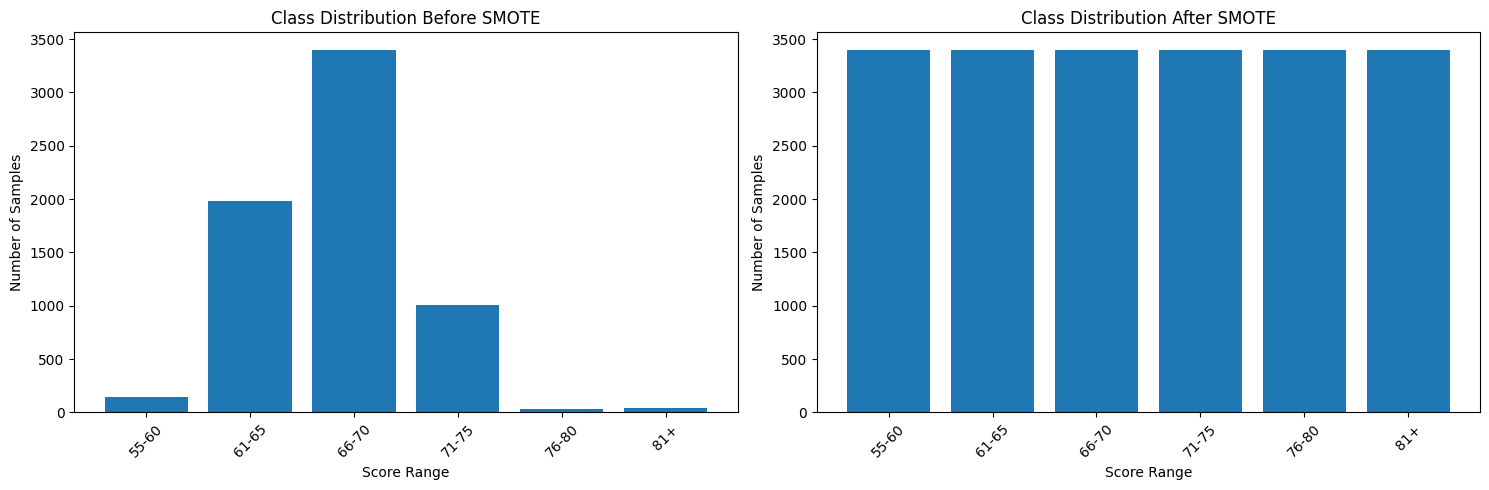

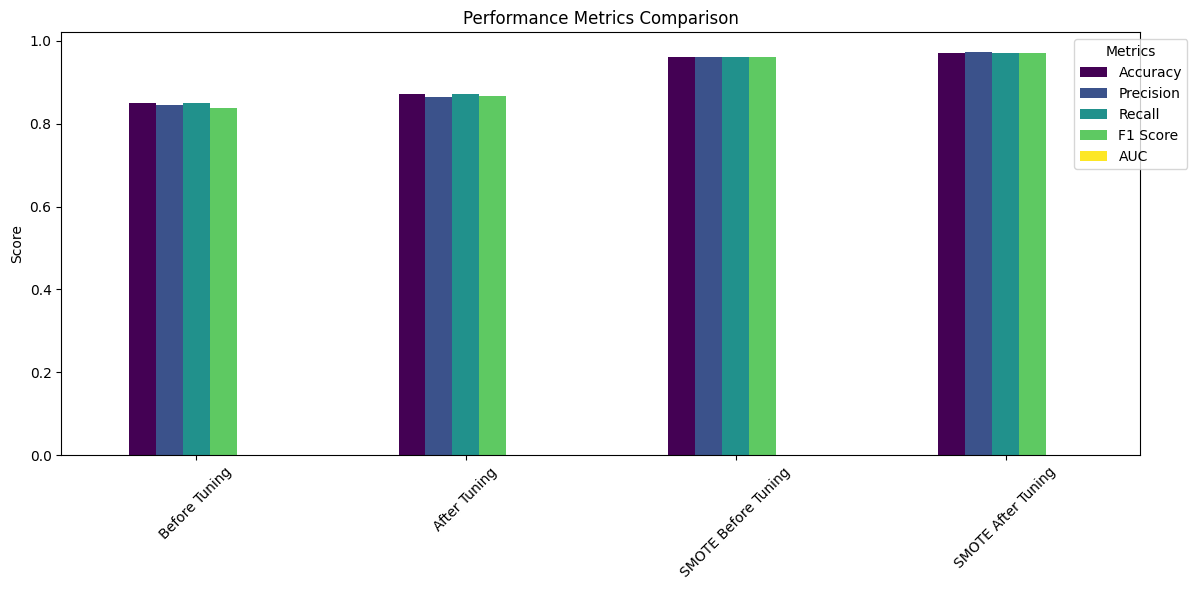

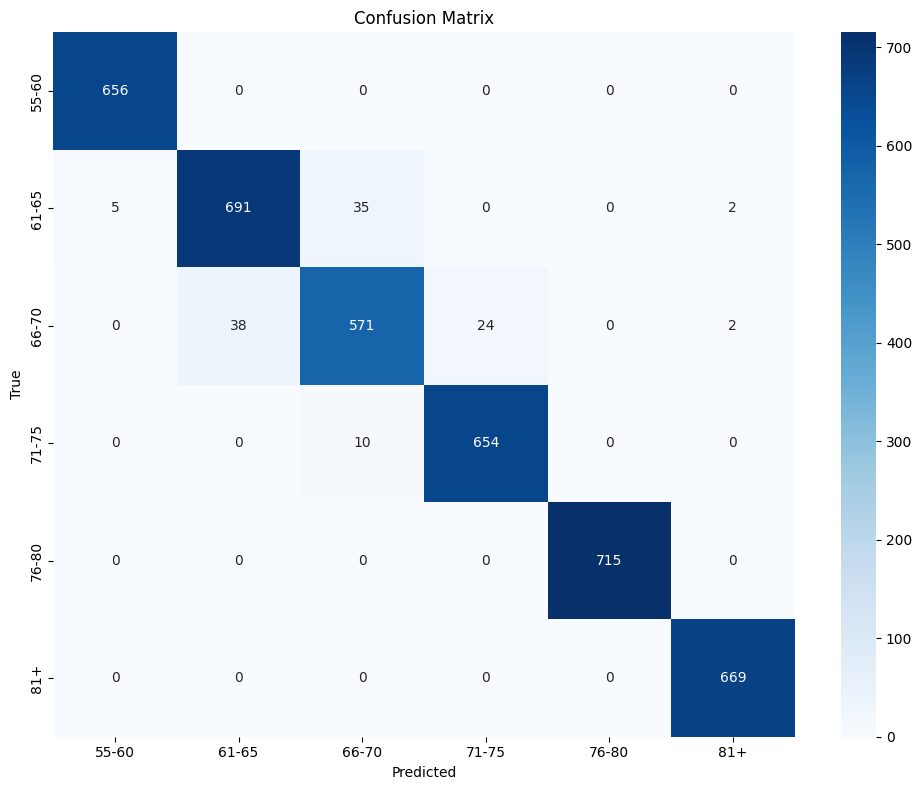

In [21]:
# Generate plots
plot_class_distribution()
plot_metrics_comparison()
plot_confusion_matrix()